# 🇺🇦 Ukrainian OCR Package - Complete Demo

This notebook demonstrates the **Ukrainian OCR Pipeline Package** with:

## Features:
- **Automatic Environment Detection** (Local vs Google Colab)
- **GPU/CPU Optimization** based on available hardware
- **GitHub Integration** for Colab (automatic cloning)
- **Two-Stage Processing**:
  1. **Stage 1**: Kraken Segmentation → Basic ALTO XML
  2. **Stage 2**: TrOCR Recognition → NER Enhancement → Enhanced ALTO

## Pipeline Components:
1. 🔍 **Kraken Segmentation** - Text line detection
2. 📄 **ALTO XML Generation** - Standard archival format
3. 🤖 **TrOCR Recognition** - Cyrillic handwritten text
4. 🏷️ **Named Entity Recognition** - Person/location extraction
5. 📝 **Surname Matching** - Genealogical surname detection
6. ✨ **ALTO Enhancement** - Semantic annotation integration

## 🚀 Environment Setup & Package Installation

In [1]:
import os
import sys
import subprocess
from pathlib import Path

# Detect environment
IS_COLAB = 'google.colab' in sys.modules
print(f"🌍 Environment: {'Google Colab' if IS_COLAB else 'Local'}")

if IS_COLAB:
    print("📥 Setting up Google Colab environment...")
    
    # Clone the repository if not already present
    if not os.path.exists('/content/ukrainian_ocr_package'):
        print("📦 Cloning Ukrainian OCR Package from GitHub...")
        !git clone https://github.com/mary-lev/ukrainian-ocr-pipeline.git /content/ukrainian_ocr_package
    
    # Change to package directory
    os.chdir('/content/ukrainian_ocr_package')
    
    # Install the package in development mode
    print("🔧 Installing package dependencies...")
    !pip install -e .[colab] --quiet
    
    # Add package to Python path
    if '/content/ukrainian_ocr_package' not in sys.path:
        sys.path.insert(0, '/content/ukrainian_ocr_package')
        
    print("✅ Google Colab setup complete!")
    
else:
    print("🏠 Running in local environment")
    # For local development, assume package is already installed or available
    if os.path.exists('../ukrainian_ocr'):
        sys.path.insert(0, '..')
        print("✅ Using local development version")
    else:
        print("📦 Using installed package version")

🌍 Environment: Local
🏠 Running in local environment
✅ Using local development version


In [2]:
# Import core libraries
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import time
from typing import Dict, List, Optional

# Import Ukrainian OCR Package
try:
    from ukrainian_ocr import UkrainianOCRPipeline
    from ukrainian_ocr.core.config import OCRPipelineConfig
    from ukrainian_ocr.utils.colab import check_gpu, download_results
    print("✅ Ukrainian OCR Package imported successfully!")
    print(f"📍 Package location: {__import__('ukrainian_ocr').__file__}")
except ImportError as e:
    print(f"❌ Failed to import Ukrainian OCR Package: {e}")
    print("Please check the installation steps above")

✅ Ukrainian OCR Package imported successfully!
📍 Package location: /mnt/ssd990/projects/tarkovsky/ukrainian_ocr_package/examples/../ukrainian_ocr/__init__.py


/home/maria/ssd990/projects/tarkovsky/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 🔧 Device Detection & Configuration

In [3]:
# Automatic device detection and optimization
print("🖥️ Hardware Detection:")
print(f"PyTorch version: {torch.__version__}")

# Check GPU availability
if torch.cuda.is_available():
    gpu_name = torch.cuda.get_device_name(0)
    gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1024**3
    print(f"✅ GPU: {gpu_name} ({gpu_memory:.1f}GB VRAM)")
    device = 'cuda'
    batch_size = 8 if gpu_memory > 8 else 4  # Adjust batch size based on GPU memory
else:
    print("⚠️ GPU not available - using CPU")
    device = 'cpu'
    batch_size = 1  # Conservative batch size for CPU

print(f"🎯 Selected device: {device}")
print(f"📦 Batch size: {batch_size}")

# Create optimized configuration
config = {
    'device': device,
    'batch_size': batch_size,
    'verbose': True,
    
    # Segmentation settings
    'segmentation': {
        'device': device,
        'padding': 8
    },
    
    # OCR settings  
    'ocr': {
        'model_path': 'cyrillic-trocr/trocr-handwritten-cyrillic',
        'device': device,
        'batch_size': batch_size
    },
    
    # NER settings - try transformers first, fallback to others
    'ner': {
        'backend': 'transformers',  # Will fallback automatically if not available
        'device': device,
        'confidence_threshold': 0.7
    },
    
    # Surname matching settings
    'surname_matching': {
        'enabled': True,
        'threshold': 0.8,
        'use_phonetic': True,
        'export_matches': True,
        # Common Ukrainian surnames for demonstration
        'surnames': [
            'Шевченко', 'Коваленко', 'Бондаренко', 'Ткаченко', 'Кравченко',
            'Петренко', 'Іваненко', 'Михайленко', 'Василенко', 'Григоренко',
            'Ковальчук', 'Савченко', 'Левченко', 'Павленко', 'Марченко',
            'Мельник', 'Коваль', 'Гончар', 'Кравець', 'Швець'
        ]
    },
    
    # Post-processing settings
    'post_processing': {
        'extract_person_regions': True,
        'clustering_eps': 300,
        'clustering_min_samples': 3
    }
}

# Apply environment-specific optimizations
if IS_COLAB:
    print("🔧 Applying Google Colab optimizations...")
    config['verbose'] = True  # More verbose for Colab
    config['save_intermediate'] = True  # Save intermediate results
    if device == 'cuda':
        config['batch_size'] = min(8, batch_size)  # Conservative for Colab GPU limits

print("✅ Configuration optimized for current environment")

🖥️ Hardware Detection:
PyTorch version: 2.7.1+cu126
⚠️ GPU not available - using CPU
🎯 Selected device: cpu
📦 Batch size: 1
✅ Configuration optimized for current environment


## 📄 Load Test Document

For this demo, we'll use a sample Ukrainian genealogical document. You can replace this with your own document.

📄 Using local document: 804-03494422-l-m-a-n2982-4-1001-00019.jpg

📊 Document Information:
   File: 804-03494422-l-m-a-n2982-4-1001-00019.jpg
   Size: 1.0 MB
   Dimensions: 3972 x 2558 pixels
   Format: JPEG


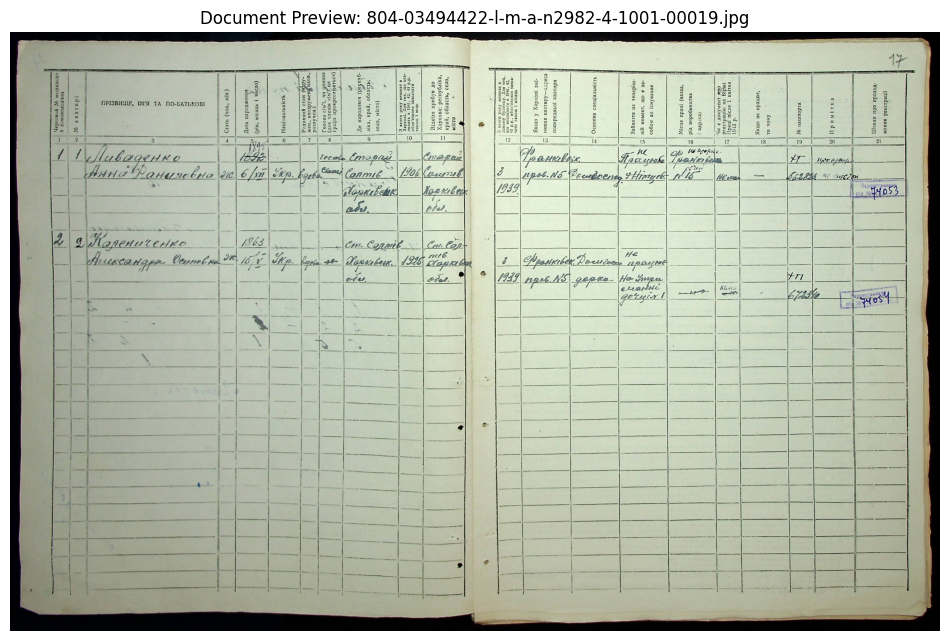

In [4]:
# Define test image paths - adjust for your setup
if IS_COLAB:
    # For Colab, provide multiple options or upload mechanism
    print("📂 Document input options for Google Colab:")
    print("1. Upload your own document")
    print("2. Use sample document (if available in repo)")
    
    # Option 1: Upload mechanism
    try:
        from google.colab import files
        print("\n📤 Upload your Ukrainian document image:")
        uploaded = files.upload()
        
        if uploaded:
            test_image_path = list(uploaded.keys())[0]
            print(f"✅ Uploaded: {test_image_path}")
        else:
            # Fallback to sample if available
            sample_path = "/content/ukrainian_ocr_package/examples/sample_document.jpg"
            if os.path.exists(sample_path):
                test_image_path = sample_path
                print(f"📄 Using sample document: {os.path.basename(test_image_path)}")
            else:
                print("❌ No document provided. Please upload an image.")
                test_image_path = None
                
    except Exception as e:
        print(f"⚠️ Upload error: {e}")
        test_image_path = None
        
else:
    # For local environment, specify your test image path
    local_test_paths = [
        "/home/maria/ssd990/projects/tarkovsky/Н-2982_4_1001/804-03494422-l-m-a-n2982-4-1001-00019.jpg",
        "../test_images/sample_ukrainian_document.jpg",
        "./sample_document.jpg"
    ]
    
    test_image_path = None
    for path in local_test_paths:
        if os.path.exists(path):
            test_image_path = path
            break
    
    if test_image_path:
        print(f"📄 Using local document: {os.path.basename(test_image_path)}")
    else:
        print("❌ No test document found. Please update the paths above.")

# Verify and display image info
if test_image_path and os.path.exists(test_image_path):
    # Load and display basic info
    image_size = os.path.getsize(test_image_path) / (1024 * 1024)  # MB
    
    try:
        with Image.open(test_image_path) as img:
            width, height = img.size
            print(f"\n📊 Document Information:")
            print(f"   File: {os.path.basename(test_image_path)}")
            print(f"   Size: {image_size:.1f} MB")
            print(f"   Dimensions: {width} x {height} pixels")
            print(f"   Format: {img.format}")
            
            # Display image preview
            plt.figure(figsize=(12, 8))
            plt.imshow(img)
            plt.title(f"Document Preview: {os.path.basename(test_image_path)}")
            plt.axis('off')
            plt.show()
            
    except Exception as e:
        print(f"⚠️ Error loading image: {e}")
        test_image_path = None
else:
    print("❌ No valid document image available for processing.")
    test_image_path = None

## 🏁 Stage 1: Document Segmentation & Basic ALTO Creation

This stage processes the document image to:
1. Detect text lines using Kraken BLLA segmentation
2. Generate basic ALTO XML with line coordinates
3. Create visualization of detected text regions

2025-09-10 22:38:55,945 - ukrainian_ocr.core.pipeline - INFO - Ukrainian OCR Pipeline initialized
2025-09-10 22:38:55,945 - ukrainian_ocr.core.pipeline - INFO - Device: cpu
2025-09-10 22:38:55,945 - ukrainian_ocr.core.pipeline - INFO - Batch size: 1
2025-09-10 22:38:55,946 - ukrainian_ocr.core.pipeline - INFO - Loading Kraken segmentation model...


🚀 STAGE 1: Document Segmentation & Basic ALTO Creation
🔧 Initializing Ukrainian OCR Pipeline...
✅ Pipeline ready (device: cpu, batch_size: 1)

🔍 Step 1: Kraken Segmentation...


2025-09-10 22:38:57,856 - ukrainian_ocr.core.pipeline - INFO - Loading TrOCR model...
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 18724.57it/s]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
2025-09-10 22:39:01,607 - ukrainian_ocr.core.pipeline - INFO - Loading NER model...
Device set to use cpu
2025-09-10 22:39:02,305 - ukrainian_ocr.core.pipeline - INFO - Loading surname matcher...


✅ Segmentation complete in 36.55s
📊 Detected 106 text lines

📝 Sample detected lines (first 5):
  Line 1: BBox [137.0, 289.0, 224.0, 324.0], Confidence: 1.00
  Line 2: BBox [203.0, 392.0, 234.0, 448.0], Confidence: 1.00
  Line 3: BBox [246.0, 293.0, 316.0, 386.0], Confidence: 1.00
  Line 4: BBox [259.0, 381.0, 299.0, 447.0], Confidence: 1.00
  Line 5: BBox [266.0, 476.0, 312.0, 573.0], Confidence: 1.00

📄 Step 2: Creating Basic ALTO XML...
✅ Basic ALTO XML created: ukrainian_ocr_output/804-03494422-l-m-a-n2982-4-1001-00019_basic_segmentation.xml
📄 File size: 0.9 KB

🎨 Step 3: Creating Segmentation Visualization...


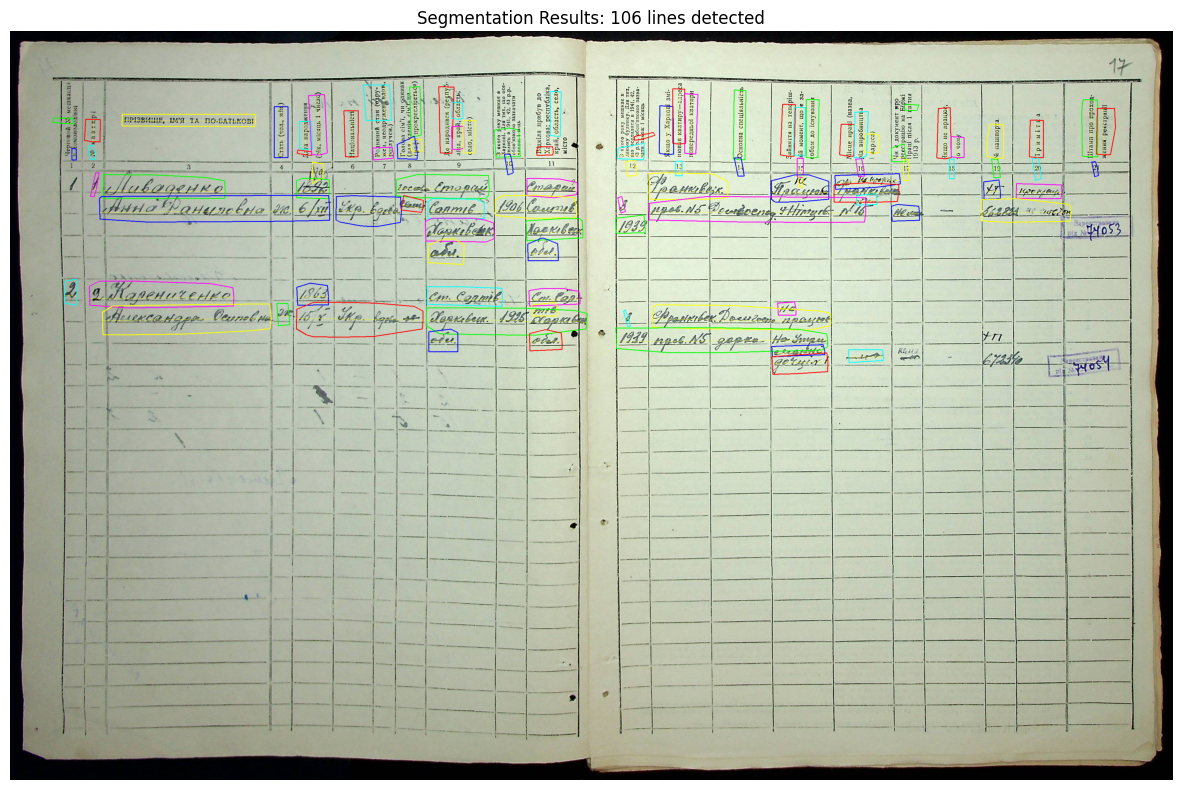

✅ Visualization saved: ukrainian_ocr_output/804-03494422-l-m-a-n2982-4-1001-00019_segmentation_viz.png

📊 STAGE 1 COMPLETE - SUMMARY:
⏱️ Processing time: 36.55s
📄 Lines detected: 106
📁 Basic ALTO XML: ukrainian_ocr_output/804-03494422-l-m-a-n2982-4-1001-00019_basic_segmentation.xml
🎨 Visualization: ukrainian_ocr_output/804-03494422-l-m-a-n2982-4-1001-00019_segmentation_viz.png

✅ Ready for Stage 2: Text Recognition & Enhancement


In [5]:
if not test_image_path:
    print("❌ Cannot proceed without a valid document image.")
    print("Please upload an image or check the file paths above.")
else:
    print("🚀 STAGE 1: Document Segmentation & Basic ALTO Creation")
    print("=" * 60)
    
    # Initialize the pipeline with our optimized config
    print("🔧 Initializing Ukrainian OCR Pipeline...")
    pipeline_config = OCRPipelineConfig.from_dict(config)
    pipeline = UkrainianOCRPipeline(config=pipeline_config)
    
    print(f"✅ Pipeline ready (device: {pipeline.device}, batch_size: {pipeline.batch_size})")
    
    # Process Stage 1: Segmentation only
    print("\n🔍 Step 1: Kraken Segmentation...")
    start_time = time.time()
    
    # Initialize segmentation component
    pipeline._init_components()
    
    # Load and segment the image
    import cv2
    image = cv2.imread(test_image_path)
    if image is None:
        raise ValueError(f"Could not load image: {test_image_path}")
    
    # Perform segmentation
    lines = pipeline.segmenter.segment_image(image)
    segmentation_time = time.time() - start_time
    
    print(f"✅ Segmentation complete in {segmentation_time:.2f}s")
    print(f"📊 Detected {len(lines)} text lines")
    
    # Display sample line information
    if lines:
        print("\n📝 Sample detected lines (first 5):")
        for i, line in enumerate(lines[:5]):
            bbox = line.get('bbox', [])
            confidence = line.get('confidence', 0)
            print(f"  Line {i+1}: BBox {bbox[:4] if len(bbox)>=4 else 'N/A'}, Confidence: {confidence:.2f}")
    
    # Create basic ALTO XML (without text recognition)
    print("\n📄 Step 2: Creating Basic ALTO XML...")
    
    # Create output directory
    output_dir = Path("./ukrainian_ocr_output")
    output_dir.mkdir(exist_ok=True)
    
    # Generate basic ALTO with segmentation data only
    basic_alto_xml = pipeline._create_alto_xml(
        Path(test_image_path), 
        image, 
        lines  # Lines without text content yet
    )
    
    # Save basic ALTO
    basic_alto_path = output_dir / f"{Path(test_image_path).stem}_basic_segmentation.xml"
    with open(basic_alto_path, 'w', encoding='utf-8') as f:
        f.write(basic_alto_xml)
    
    print(f"✅ Basic ALTO XML created: {basic_alto_path}")
    print(f"📄 File size: {os.path.getsize(basic_alto_path) / 1024:.1f} KB")
    
    # Create segmentation visualization
    print("\n🎨 Step 3: Creating Segmentation Visualization...")
    
    # Create visualization
    vis_image = image.copy()
    colors = [(0, 255, 0), (255, 0, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255), (0, 255, 255)]
    
    for idx, line in enumerate(lines[:100]):  # Limit visualization to first 100 lines
        color = colors[idx % len(colors)]
        
        # Draw polygon if available
        polygon = line.get('polygon', [])
        if polygon and len(polygon) >= 3:
            pts = np.array(polygon, np.int32)
            cv2.polylines(vis_image, [pts], True, color, 2)
        
        # Draw baseline
        baseline = line.get('baseline', [])
        if baseline and len(baseline) >= 2:
            baseline_pts = np.array(baseline, np.int32)
            cv2.polylines(vis_image, [baseline_pts], False, (0, 255, 255), 1)
    
    # Save visualization
    vis_path = output_dir / f"{Path(test_image_path).stem}_segmentation_viz.png"
    cv2.imwrite(str(vis_path), vis_image)
    
    # Display visualization
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(vis_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Segmentation Results: {len(lines)} lines detected")
    plt.axis('off')
    plt.show()
    
    print(f"✅ Visualization saved: {vis_path}")
    
    # Stage 1 Summary
    print("\n📊 STAGE 1 COMPLETE - SUMMARY:")
    print(f"⏱️ Processing time: {segmentation_time:.2f}s")
    print(f"📄 Lines detected: {len(lines)}")
    print(f"📁 Basic ALTO XML: {basic_alto_path}")
    print(f"🎨 Visualization: {vis_path}")
    print("\n✅ Ready for Stage 2: Text Recognition & Enhancement")
    
    # Store results for Stage 2
    stage1_results = {
        'image_path': test_image_path,
        'image': image,
        'lines': lines,
        'segmentation_time': segmentation_time,
        'basic_alto_path': basic_alto_path,
        'output_dir': output_dir
    }

## 🤖 Stage 2: Text Recognition, NER & ALTO Enhancement

This stage builds upon Stage 1 results to:
1. Recognize text content using TrOCR
2. Extract named entities (persons, locations)
3. Find surname matches for genealogical research
4. Create enhanced ALTO XML with semantic annotations
5. Generate comprehensive processing reports

In [6]:
if 'stage1_results' not in locals():
    print("❌ Stage 1 must be completed first. Please run the previous cell.")
else:
    print("🚀 STAGE 2: Text Recognition, NER & ALTO Enhancement")
    print("=" * 60)
    
    # Extract Stage 1 results
    image = stage1_results['image']
    lines = stage1_results['lines']
    output_dir = stage1_results['output_dir']
    
    print(f"📄 Processing {len(lines)} segmented lines")
    
    # Step 1: TrOCR Text Recognition
    print("\n🤖 Step 1: TrOCR Text Recognition...")
    print("⏳ This may take several minutes depending on document size and hardware")
    
    start_time = time.time()
    
    # Process lines with TrOCR
    lines_with_text = pipeline.ocr_processor.process_lines(image, lines)
    ocr_time = time.time() - start_time
    
    # Count successful recognitions
    recognized_lines = [l for l in lines_with_text if l.get('text', '').strip()]
    
    print(f"✅ OCR complete in {ocr_time:.2f}s")
    print(f"📊 Recognized text in {len(recognized_lines)}/{len(lines)} lines")
    
    # Display sample recognized text
    print("\n📝 Sample recognized text (first 10 lines):")
    for i, line in enumerate(recognized_lines[:10]):
        text = line.get('text', '')
        confidence = line.get('confidence', 0)
        print(f"  {i+1}. '{text}' (confidence: {confidence:.2f})")
    
    # Step 2: Named Entity Recognition
    print("\n🏷️ Step 2: Named Entity Recognition...")
    
    start_time = time.time()
    ner_results = pipeline.ner_extractor.extract_entities_from_lines(lines_with_text)
    ner_time = time.time() - start_time
    
    all_entities = ner_results.get('all_entities', [])
    entities_by_line = ner_results.get('entities_by_line', {})
    
    print(f"✅ NER complete in {ner_time:.2f}s")
    print(f"📊 Found {len(all_entities)} entities in {len(entities_by_line)} lines")
    print(f"🧠 Backend: {ner_results.get('backend', 'unknown')}")
    
    # Display entity statistics
    if all_entities:
        entity_types = {}
        for entity in all_entities:
            label = entity.get('label', 'UNKNOWN')
            entity_types[label] = entity_types.get(label, 0) + 1
        
        print("\n🏷️ Entity types found:")
        for entity_type, count in entity_types.items():
            print(f"  {entity_type}: {count}")
            
        # Show sample entities
        print("\n📝 Sample entities:")
        for entity in all_entities[:10]:
            print(f"  '{entity.get('text', '')}' -> {entity.get('label', 'UNKNOWN')}")
    else:
        print("ℹ️ No entities found - this may be normal for documents with short text fragments")
    
    # Step 3: Surname Matching
    print("\n👨‍👩‍👧‍👦 Step 3: Genealogical Surname Matching...")
    
    start_time = time.time()
    surname_matches = pipeline.surname_matcher.find_in_lines(lines_with_text)
    surname_time = time.time() - start_time
    
    print(f"✅ Surname matching complete in {surname_time:.2f}s")
    print(f"📊 Found {len(surname_matches)} surname matches")
    
    if surname_matches:
        # Get unique surnames
        unique_surnames = list(set(m.matched_surname for m in surname_matches))
        print(f"👥 Unique surnames: {len(unique_surnames)}")
        
        # Display matches
        print("\n👨‍👩‍👧‍👦 Surname matches found:")
        for match in surname_matches[:10]:  # Show first 10
            print(f"  '{match.found_text}' -> '{match.matched_surname}' (confidence: {match.confidence:.2f})")
            if match.context:
                print(f"    Context: {match.context}")
        
        if len(surname_matches) > 10:
            print(f"    ... and {len(surname_matches) - 10} more matches")
        
        # Export surname matches
        matches_file = output_dir / f"{Path(test_image_path).stem}_surname_matches.json"
        pipeline.surname_matcher.export_matches(surname_matches, str(matches_file))
        print(f"💾 Surname matches exported: {matches_file}")
    else:
        print("ℹ️ No surname matches found")
    
    # Step 4: Create Enhanced ALTO XML
    print("\n✨ Step 4: Creating Enhanced ALTO XML...")
    
    # Create complete ALTO XML with text content
    complete_alto_xml = pipeline._create_alto_xml(
        Path(test_image_path), 
        image, 
        lines_with_text  # Now with recognized text
    )
    
    # Save complete ALTO
    complete_alto_path = output_dir / f"{Path(test_image_path).stem}_complete_alto.xml"
    with open(complete_alto_path, 'w', encoding='utf-8') as f:
        f.write(complete_alto_xml)
    
    print(f"✅ Complete ALTO XML created: {complete_alto_path}")
    
    # If we have entities, create enhanced ALTO
    enhanced_alto_path = None
    if entities_by_line:
        # Map entities to line IDs for enhancement
        entities_by_line_id = {}
        for idx, line in enumerate(lines_with_text):
            line_id = f"line_{idx}"
            line_text = line.get('text', '')
            
            # Find entities for this line
            line_entities = []
            for entity in all_entities:
                if entity.get('text', '') in line_text:
                    line_entities.append(entity)
            
            if line_entities:
                entities_by_line_id[line_id] = {'entities': line_entities}
        
        if entities_by_line_id:
            enhanced_alto_path = output_dir / f"{Path(test_image_path).stem}_enhanced_alto.xml"
            pipeline.alto_enhancer.enhance_alto_with_ner(
                str(complete_alto_path),
                entities_by_line_id, 
                str(enhanced_alto_path)
            )
            print(f"✅ Enhanced ALTO XML created: {enhanced_alto_path}")
        
    # Step 5: Generate Processing Report
    print("\n📊 Step 5: Generating Processing Report...")
    
    total_time = stage1_results['segmentation_time'] + ocr_time + ner_time + surname_time
    
    processing_report = {
        'document': {
            'filename': os.path.basename(test_image_path),
            'path': test_image_path,
            'dimensions': f"{image.shape[1]}x{image.shape[0]}",
            'size_mb': os.path.getsize(test_image_path) / (1024 * 1024)
        },
        'processing': {
            'total_time': total_time,
            'segmentation_time': stage1_results['segmentation_time'],
            'ocr_time': ocr_time,
            'ner_time': ner_time,
            'surname_matching_time': surname_time,
            'device': device,
            'batch_size': batch_size
        },
        'results': {
            'lines_detected': len(lines),
            'lines_with_text': len(recognized_lines),
            'entities_found': len(all_entities),
            'surname_matches': len(surname_matches),
            'unique_surnames': len(set(m.matched_surname for m in surname_matches)) if surname_matches else 0
        },
        'output_files': {
            'basic_alto': str(stage1_results['basic_alto_path']),
            'complete_alto': str(complete_alto_path),
            'enhanced_alto': str(enhanced_alto_path) if enhanced_alto_path else None,
            'surname_matches': str(matches_file) if surname_matches else None,
            'visualization': str(stage1_results.get('vis_path', ''))
        }
    }
    
    # Save processing report
    report_path = output_dir / f"{Path(test_image_path).stem}_processing_report.json"
    with open(report_path, 'w', encoding='utf-8') as f:
        json.dump(processing_report, f, indent=2, ensure_ascii=False, default=str)
    
    print(f"✅ Processing report saved: {report_path}")
    
    # Display final summary
    print("\n📊 STAGE 2 COMPLETE - FINAL SUMMARY:")
    print("=" * 50)
    print(f"📄 Document: {processing_report['document']['filename']}")
    print(f"⏱️ Total processing time: {total_time:.2f}s")
    print(f"🔍 Lines detected: {processing_report['results']['lines_detected']}")
    print(f"📝 Lines with text: {processing_report['results']['lines_with_text']}")
    print(f"🏷️ Entities found: {processing_report['results']['entities_found']}")
    print(f"👥 Surname matches: {processing_report['results']['surname_matches']}")
    print(f"🖥️ Processing device: {device}")
    
    print("\n📁 Generated Files:")
    for file_type, file_path in processing_report['output_files'].items():
        if file_path and os.path.exists(file_path):
            size_kb = os.path.getsize(file_path) / 1024
            print(f"  ✅ {file_type}: {os.path.basename(file_path)} ({size_kb:.1f} KB)")
        else:
            print(f"  ➖ {file_type}: Not created")
    
    print("\n🎉 Ukrainian OCR Pipeline processing completed successfully!")

🚀 STAGE 2: Text Recognition, NER & ALTO Enhancement
📄 Processing 106 segmented lines

🤖 Step 1: TrOCR Text Recognition...
⏳ This may take several minutes depending on document size and hardware
✅ OCR complete in 389.84s
📊 Recognized text in 106/106 lines

📝 Sample recognized text (first 10 lines):
  1. '4.' (confidence: 0.95)
  2. 'го' (confidence: 0.95)
  3. 'гдⷭ҇ь.' (confidence: 0.95)
  4. '6.' (confidence: 0.95)
  5. '4' (confidence: 0.95)
  6. 'прізвише, їм'я та по-батькові.' (confidence: 0.95)
  7. 'Ливоденко' (confidence: 0.95)
  8. 'гдⷭ҇ь къ' (confidence: 0.95)
  9. 'є҆го̀.' (confidence: 0.95)
  10. 'гоⷭ҇' (confidence: 0.95)

🏷️ Step 2: Named Entity Recognition...
✅ NER complete in 0.24s
📊 Found 0 entities in 0 lines
🧠 Backend: transformers_roberta_large_russian
ℹ️ No entities found - this may be normal for documents with short text fragments

👨‍👩‍👧‍👦 Step 3: Genealogical Surname Matching...
✅ Surname matching complete in 0.11s
📊 Found 0 surname matches
ℹ️ No surname matches fou

## 📥 Download Results (Google Colab Only)

If you're running this in Google Colab, use this cell to download all generated files.

In [7]:
if IS_COLAB and 'processing_report' in locals():
    print("📥 Preparing files for download...")
    
    try:
        from ukrainian_ocr.utils.colab import download_results
        
        # Download all results
        output_dir = Path("./ukrainian_ocr_output")
        if output_dir.exists():
            download_results(
                str(output_dir),
                filename=f"{Path(test_image_path).stem}_ukrainian_ocr_results.zip"
            )
            print("✅ All files packaged and download started!")
        else:
            print("❌ Output directory not found")
            
    except Exception as e:
        print(f"⚠️ Download error: {e}")
        print("You can manually download files from the file browser on the left.")
        
elif not IS_COLAB:
    print("📁 Local environment - files are saved in the './ukrainian_ocr_output' directory")
    if 'processing_report' in locals():
        output_dir = Path("./ukrainian_ocr_output")
        if output_dir.exists():
            files = list(output_dir.glob("*"))
            print(f"📄 {len(files)} files generated:")
            for file_path in files:
                size_kb = file_path.stat().st_size / 1024
                print(f"  • {file_path.name} ({size_kb:.1f} KB)")
        
else:
    print("ℹ️ Complete the processing stages above to generate downloadable results.")

📁 Local environment - files are saved in the './ukrainian_ocr_output' directory
📄 4 files generated:
  • 804-03494422-l-m-a-n2982-4-1001-00019_processing_report.json (1.0 KB)
  • 804-03494422-l-m-a-n2982-4-1001-00019_basic_segmentation.xml (0.9 KB)
  • 804-03494422-l-m-a-n2982-4-1001-00019_segmentation_viz.png (12340.0 KB)
  • 804-03494422-l-m-a-n2982-4-1001-00019_complete_alto.xml (40.1 KB)


## 📋 Usage Summary & Next Steps

### What This Notebook Accomplished:

1. **✅ Environment Detection**: Automatically configured for Local or Google Colab
2. **✅ Hardware Optimization**: GPU/CPU detection with optimized batch sizes
3. **✅ Document Segmentation**: Kraken BLLA text line detection
4. **✅ Text Recognition**: TrOCR Cyrillic handwritten text recognition
5. **✅ Named Entity Recognition**: Person/location extraction with multiple backends
6. **✅ Surname Matching**: Genealogical surname detection with fuzzy matching
7. **✅ ALTO XML Generation**: Archival-standard output with coordinates
8. **✅ Enhanced ALTO**: Semantic annotations with NER entities

### Generated Files:
- **Basic ALTO XML**: Segmentation with line coordinates
- **Complete ALTO XML**: Full text transcription with confidence scores
- **Enhanced ALTO XML**: With named entity semantic annotations
- **Surname Matches JSON**: Genealogical surname findings
- **Segmentation Visualization**: Visual representation of detected text lines
- **Processing Report**: Comprehensive statistics and metadata

### Next Steps:
1. **Import ALTO files** into eScriptorium for manual correction
2. **Analyze surname matches** for genealogical research
3. **Use enhanced ALTO** for digital humanities research
4. **Process additional documents** using the same pipeline
5. **Customize surname lists** for specific family research

### For More Information:
- 📖 **Package Documentation**: Check the repository README
- 🔧 **Configuration Options**: Modify the config dictionary above
- 🏷️ **NER Backends**: Try different backends (spacy, transformers, rule-based)
- 👥 **Surname Lists**: Add your own surname databases

---

**🇺🇦 Ukrainian OCR Pipeline** - Specialized for Ukrainian historical documents and genealogical research.